In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from astropy import wcs
import matplotlib
import coop_setup_funcs as csf
from astropy.cosmology import Planck15 as cosmo, z_at_value
from astropy import units as u

In [2]:
def get_all_cl_points(filename):
    file      = np.loadtxt(filename)
    theta,phi = file[:,0], file[:,1]
    dec       = []
    ra        = []
    for i in range(len(theta)):
        dec.append(ThetaPhitoDeclRa(theta[i],phi[i])[0])
        ra.append(ThetaPhitoDeclRa(theta[i],phi[i])[1])

    ra        = np.asarray(ra)
    dec       = np.asarray(dec)
    in_region = (ra>lonmin) & (ra < lonmax) & (dec < latmax) & (dec > latmin)
    dec       = dec[in_region]
    ra        = ra[in_region]
    return (ra,dec)
    peakfile.close()
    
def get_peakinfo(filename):
    peakfile = fits.open(filename)
    peakinfo = peakfile[0].data
    rot_angle = peakinfo[:,3]
    theta,phi = peakinfo[:,1], peakinfo[:,2]
    dec = []
    ra  = []
    for i in range(len(theta)):
        dec.append(csf.ThetaPhitoRaDec(theta[i],phi[i])[1])
        ra.append(csf.ThetaPhitoRaDec(theta[i],phi[i])[0])

    ra = np.asarray(ra)
    dec = np.asarray(dec)
    in_region = (ra>pt_lonmin) & (ra < pt_lonmax) & (dec < pt_latmax) & (dec > pt_latmin)
    dec = dec[in_region]
    rot_angle = rot_angle[in_region]
    ra = ra[in_region]
    return (rot_angle,ra,dec)
    peakfile.close()

def get_einfo(filename, ra_h, dec_h):
    ecc_map0 = hp.read_map(filename, field=0)
    ecc_map1 = hp.read_map(filename, field=1)    
    ecc_map2 = hp.read_map(filename, field=2)
    
    pixels = hp.ang2pix(4096, ra_h, dec_h, lonlat=True)
    e = np.sqrt((ecc_map1**2 + ecc_map2**2)/ecc_map0**2)
    return e[pixels]
    
def get_vector_components(rot_angle):
    U_arr = np.zeros(len(rot_angle))
    V_arr = np.zeros(len(rot_angle))
    m = 0
    for r in rot_angle:

        if (r <= np.pi/2.) or (r > 3*np.pi/2.):
            U = 1/np.sqrt(1+np.tan(r)**2)
        else:
            U = -1/np.sqrt(1+np.tan(r)**2)
        V = U * np.tan(r)
        U_arr[m] = U
        V_arr[m] = V
        m += 1
    return U_arr, V_arr

def read_amp_map(amp_file):
    amp_map = fits.open(amp_file)
    amp_map[1].header['TTYPE3'] = 'ID2'
    amp_map.writeto(amp_file, overwrite=True)
    amp_map.close()
    return hp.read_map(amp_file, field=0)

## Find percentage agreement between different smoothing scales

In [3]:
latmin = -6
latmax = 2
lonmin = 0
lonmax = 18

pt_latmin = latmin + 0.1
pt_latmax = latmax - 0.1
pt_lonmin = lonmin + 0.1
pt_lonmax = lonmax - 0.1

In [4]:
# run this if latrange and lonrange cover full area
# ras_6  = []
# ras_14 = []
# ras_18 = []
# for reg in range(12):
#     rot_angle_6, ra_6, dec_6    = get_peakinfo("/mnt/scratch-lustre/mlokken/stacking/ACT+Planck/{0}/ACTxDES_lambdagt10_reg{0}_1632_1832Mpc_nugt2_egtpt3_6pt1_pks.fits".format(reg))
#     ras_6.extend(ra_6)
#     rot_angle_14, ra_14, dec_14 = get_peakinfo("/mnt/scratch-lustre/mlokken/stacking/ACT+Planck/{0}/ACTxDES_lambdagt10_reg{0}_1632_1832Mpc_nugt2_egtpt3_13pt9_pks.fits".format(reg))
#     ras_14.extend(ra_14)
#     rot_angle_18, ra_18, dec_18 = get_peakinfo("/mnt/scratch-lustre/mlokken/stacking/ACT+Planck/{0}/ACTxDES_lambdagt10_reg{0}_1632_1832Mpc_nugt2_egtpt3_17pt8_pks.fits".format(reg))
#     ras_18.extend(ra_18)

In [4]:
#GRF
rot_angle_grf_nocuts, ra_grf_nocuts, dec_grf_nocuts = get_peakinfo("/mnt/scratch-lustre/mlokken/stacking/GRF_buzzspec/0/GRF_lambdagt10_reg0_1418_1945Mpc_13pt9_gfield_pks.fits")
rot_angle_grf, ra_grf, dec_grf = get_peakinfo("/mnt/scratch-lustre/mlokken/stacking/GRF_buzzspec/0/GRF_lambdagt10_reg0_1418_1945Mpc_nugt2_egtpt3_13pt9_gfield_pks.fits")
#Buzzard
rot_angle_b = []
ra_b = []
dec_b = []

rot_angle_b_nocuts = []
ra_b_nocuts = []
dec_b_nocuts = []

for reg in range(24):
    rot_angle, ra, dec = get_peakinfo("/mnt/scratch-lustre/mlokken/stacking/Buzzard_tSZ_rmpks/{0}/Buzzard_lambdagt10_reg{0}_1418_1945Mpc_nugt2_egtpt3_13pt9_pks.fits".format(reg))
    rot_angle_noc, ra_noc, dec_noc = get_peakinfo("/mnt/scratch-lustre/mlokken/stacking/Buzzard_tSZ_rmpks/{0}/Buzzard_lambdagt10_reg{0}_1418_1945Mpc_allnu_alle_13pt9_pks.fits".format(reg))
    rot_angle_b.append(rot_angle)
    ra_b.append(ra)
    dec_b.append(dec)
    rot_angle_b_nocuts.append(rot_angle_noc)
    ra_b_nocuts.append(ra_noc)
    dec_b_nocuts.append(dec_noc)

rot_angle_b = np.concatenate(rot_angle_b)
ra_b = np.concatenate(ra_b)
dec_b = np.concatenate(dec_b)
rot_angle_b_nocuts = np.concatenate(rot_angle_b_nocuts)
ra_b_nocuts = np.concatenate(ra_b_nocuts)
dec_b_nocuts = np.concatenate(dec_b_nocuts)

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


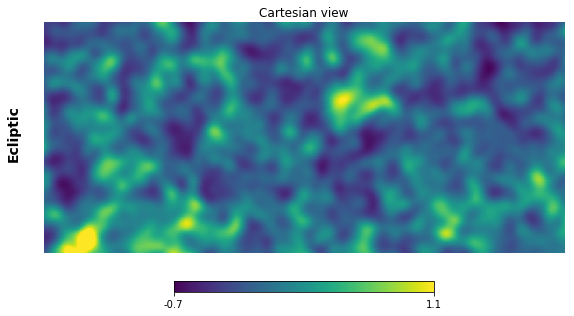

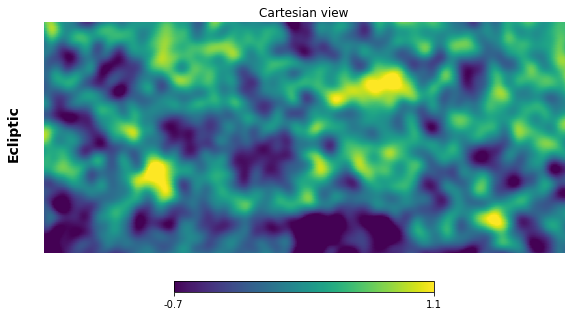

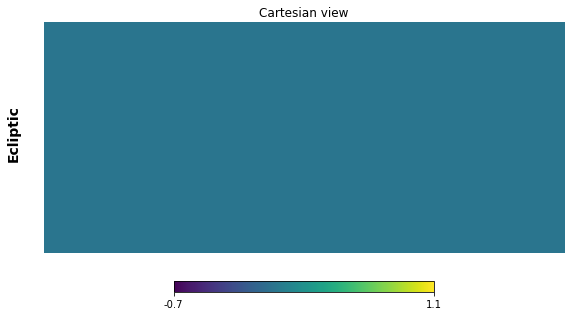

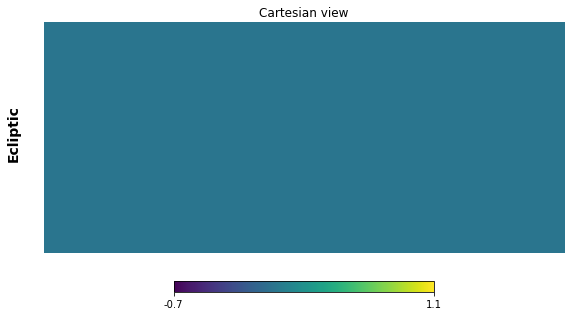

In [5]:
nd_map_smooth_b = read_amp_map("/mnt/raid-cita/mlokken/buzzard/number_density_maps/des_reg/3_zbins_grf_comparison/buzzard_redmagic_highdens_zbin2_od_map_nosmooth_AMPLITUDE_fwhm28a.fits")
nd_map_flat_b = hp.cartview(nd_map_smooth_b, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True, coord='E', min=-.7, max=1.1)
nd_map_smooth_grf = read_amp_map("/mnt/raid-cita/mlokken/GRF_buzzspec/grf_gfield_buzzardspec_zbin2_0_AMPLITUDE_fwhm28a.fits")
nd_map_flat_grf = hp.cartview(nd_map_smooth_grf, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True, coord='E', min=-.7, max=1.1)
ymap_smooth_b = read_amp_map("/mnt/raid-cita/mlokken/buzzard/ymaps/ymap_buzzard_COMBINED_NM50_Nz16_nside4096_v01_actbeam.fits")
ymap_flat_b = hp.cartview(ymap_smooth_b, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True, coord='E', min=-.7, max=1.1)
ymap_smooth_grf = read_amp_map("/mnt/raid-cita/mlokken/GRF_buzzspec/grf_yfield_buzzardspec_zbin2_0.fits")
ymap_flat_grf = hp.cartview(ymap_smooth_grf, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True, coord='E', min=-.7, max=1.1)

In [6]:
w = wcs.WCS(naxis=2)

height = float(nd_map_flat_b.shape[0])
length = float(nd_map_flat_b.shape[1])
w = wcs.WCS(naxis=2)
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmin-latmax)/height, (latmin+latmax)/2.


w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]
Xpix_b,Ypix_b = w.all_world2pix(ra_b,dec_b,0)
Xpix_b_noc,Ypix_b_noc = w.all_world2pix(ra_b_nocuts,dec_b_nocuts,0)

[400. 178.]
[ 9. -2.]
[-0.0225     -0.02247191]


(-42.179357547903585, 799.5)


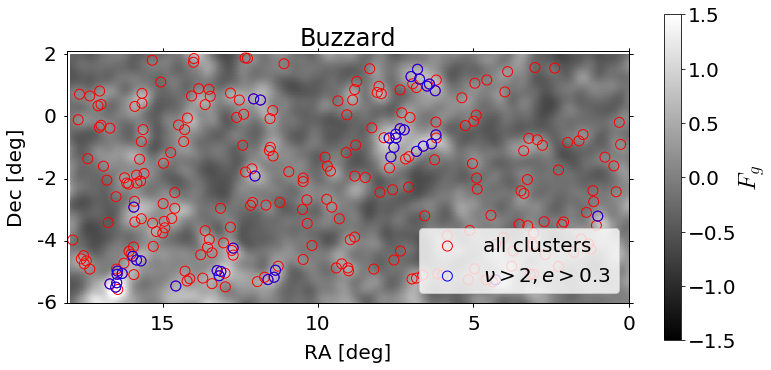

In [8]:
# Make the figure

fig = plt.figure(figsize=(2.1*6,6))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)
nrows = 1
ax1 = plt.subplot(nrows, 1, 1, projection=w)
im = ax1.imshow(nd_map_flat_b[::-1], vmin=-1.5, vmax=1.5, cmap='gray')
ax1.set_xticks([])
ax1.set_xticklabels([])
U_arr_b, V_arr_b = get_vector_components(rot_angle_b)

# ax1.quiver(Xpix_b, Ypix_b, -U_arr_b, V_arr_b, width=0.005, color = 'w', scale_units = 'inches', scale = 1.8)
# ax1.quiver(Xpix_b, Ypix_b, U_arr_b, -V_arr_b, width=0.005, color = 'w', scale_units = 'inches', scale = 1.8)

ax1.scatter(Xpix_b_noc, Ypix_b_noc, s=100,edgecolor='r', facecolor='none', label='all clusters')
ax1.scatter(Xpix_b, Ypix_b, s=100,edgecolor='b', facecolor='none', label=r'$\nu>2, e>0.3$')
plt.legend(loc='lower right')
print(ax1.get_xlim())
ax1.set_ylim([355.5, -5])
ax1.set_xlim([-5,799.5])
plt.title("Buzzard")
plt.xlabel("RA [deg]", fontsize=20)
plt.ylabel("Dec [deg]", fontsize=20)
c = plt.colorbar(im)
c.set_label("$F_g$", usetex=True, fontsize=25)
plt.savefig("/home/mlokken/oriented_stacking/plots/buzzard_odmap_zbin2_clusters_nu_e_cuts.png", dpi=300)

In [9]:
w = wcs.WCS(naxis=2)

height = float(nd_map_flat_grf.shape[0])
length = float(nd_map_flat_grf.shape[1])
w = wcs.WCS(naxis=2)
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmin-latmax)/height, (latmin+latmax)/2.


w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]
Xpix_grf,Ypix_grf = w.all_world2pix(ra_grf,dec_grf,0)
Xpix_grf_noc,Ypix_grf_noc = w.all_world2pix(ra_grf_nocuts,dec_grf_nocuts,0)

[400. 178.]
[ 9. -2.]
[-0.0225     -0.02247191]


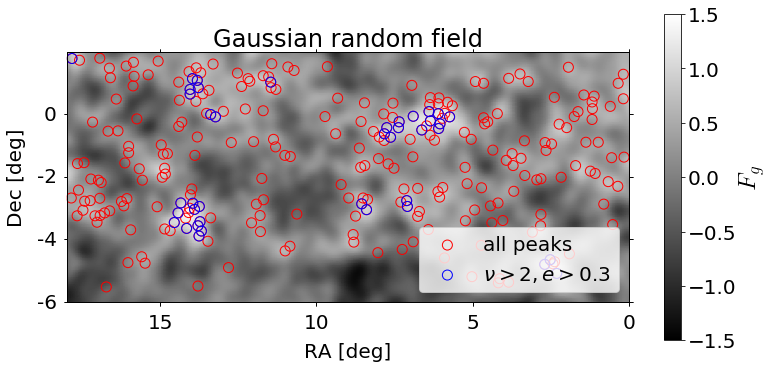

In [10]:
# Make the figure

fig = plt.figure(figsize=(2.1*6,6))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)
nrows = 1
ax1 = plt.subplot(nrows, 1, 1, projection=w)
im = ax1.imshow(nd_map_flat_grf[::-1], vmin=-1.5, vmax=1.5, cmap='gray')
ax1.set_xticks([])
ax1.set_xticklabels([])
U_arr_grf, V_arr_grf = get_vector_components(rot_angle_grf)

# ax1.quiver(Xpix_grf, Ypix_grf, -U_arr_grf, V_arr_grf, width=0.005, color = 'w', scale_units = 'inches', scale = 1.8)
# ax1.quiver(Xpix_grf, Ypix_grf, U_arr_grf, -V_arr_grf, width=0.005, color = 'w', scale_units = 'inches', scale = 1.8)
ax1.scatter(Xpix_grf_noc, Ypix_grf_noc, s=100,edgecolor='r', facecolor='none', label='all peaks')
ax1.scatter(Xpix_grf, Ypix_grf, s=100,edgecolor='b', facecolor='none', label=r'$\nu>2, e>0.3$')
plt.legend(loc='lower right')
# ax1.set_ylim([800,500])
# ax1.set_xlim([200,800])
plt.title("Gaussian random field")
plt.xlabel("RA [deg]", fontsize=20)
plt.ylabel("Dec [deg]", fontsize=20)
c= plt.colorbar(im)
c.set_label("$F_g$", usetex=True, fontsize=25)
plt.savefig("/home/mlokken/oriented_stacking/plots/grf_odmap_zbin2_clusters_nu_e_cuts.png", dpi=300)